## Look at the nouns in the conversation threads. Create a noun matrix of the tf-idf means across all subreddits. Use cosine similarity to ensemble the personality matrix

In [1187]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import pprint
import spacy
import matplotlib.pyplot as plt
import time
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score,classification_report
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn import cluster, datasets, preprocessing, metrics
%matplotlib inline
stoppers=stopwords.words('english')
stoppers= [x.lower() for x in stoppers]
tokenizer = SpaceTokenizer()

In [1188]:
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit']]
df=pd.read_json(subreddit_list[0])

Let's also get the nouns in the title; we can check to see to recurring nouns for 'memes'

### Create the categorical variables

2 Ways:
* By predetermined categories
* By Bag of Words


aggression.csv, anarchy.json, animals.csv, art_and_literature.csv, cars.csv, conservative_terms.json, controversial_terms.json, drugs.json, eco_friendly.csv, environmental.json, feminine_terms, fitness.json, gaming.json, liberal_terms.json, marxism.json, music_and_television.csv, outdoors_words.csv, romantic_words.csv, sadness_sorry.csv, sports.json, technical_terms.json, theological.json, video_games.csv, vulgar_terms.json, weirdo.json

# Comb through the category lists and remove any non-exclusive words and repeated words

### We read in our category lists here

In [1918]:
category_lists=["aggression.csv", "anarchy.json", "animals.csv", "art_and_literature.csv", "cars.csv", 
                "companies.csv",\
                "conservative_terms.json", "controversial_terms.json", "drugs.json", "eco_friendly.csv",\
                "environmental.json", "feminine_terms.csv", "fitness.json", "gaming.json", "liberal_terms.json",\
                "marxism.json", "music_and_television.csv", "outdoors_words.csv", "romantic_words.csv",\
                "sadness_sorry.csv","sentiment_pos.csv","sentiment_neg.csv", "sentiment_neutral.csv", \
                "sexual_terms.json", "sports.json", "technical_terms.json", \
                "theological.json", "video_games.csv", "vulgar_terms.json", "weirdo.json"]
category_lists2=["aggression.csv", "animals.csv", "art_and_literature.csv", "cars.csv", "companies.csv",\
                "conservative_terms.json", "controversial_terms.json", "drugs.json", "eco_friendly.csv",\
                "environmental.json", "feminine_terms.csv", "fitness.json", "gaming.json", "liberal_terms.json",\
                "marxism.json", "music_and_television.csv", "outdoors_words.csv", "romantic_words.csv",\
                "sadness_sorry.csv","sentiment_pos.csv","sentiment_neg.csv", "sentiment_neutral.csv", \
                "sexual_terms.json", "sports.json", "technical_terms.json", \
                "theological.json", "video_games.csv", "vulgar_terms.json", "weirdo.json"]
base_extension="/Users/thomas/GA-DSI/projects/projects-capstone/Work 2, Personalities/Key Terms Lists/"

In [1899]:
# Here we are just reading in the category word lists into a list. Out put is a list of category lists.
i=0
category_word_list=[]
for i in range(len(category_lists)):
    extension=base_extension+category_lists[i]
    if category_lists[i][-3:]=='csv':
        df=pd.read_csv(extension)
        words=[word for word in df.iloc[:,0]]
    elif category_lists[i]=='sexual_terms.json':
        df=pd.read_json(extension)
        words=[word for word in df.iloc[:,0]]
    else:
        df=pd.read_table(extension)
        info=df.columns[0]
        info=info.strip(':').strip(',').split('\\"')
        words=[]
        for i in range(1,len(info)):
            if i%2==0:
                if len(info[i])>4:
                    words.append(info[i])
    category_word_list.append(words)
category_count=[]

### Quick function to remove duplicates from categories and non-exclusive words from categories

In [1900]:
all_words=[]
new_cat_word_list=[]
i=0
for words in category_word_list:
    new_cat_word_list.append([str(x).lower() for x in words])
    cat_words=pd.DataFrame(new_cat_word_list[-1]).iloc[:,0].value_counts()
    del_words=[]
    for word in range(len(cat_words)):
            ####
            # This number below will remove words from a cat_list if they occur more than 'n' times
        if cat_words[word]>2:
            if cat_words[word] not in del_words:
                del_words.append(cat_words.index[word])
    for word in del_words:
        while word in new_cat_word_list[-1]:
            new_cat_word_list[-1].remove(word)
category_word_list=new_cat_word_list
for words in category_word_list:
    all_words.extend(words)
words=pd.DataFrame(all_words).iloc[:,0].value_counts()
del_words=[]
for word in range(len(words)):
        ####
        #This number will remove words that occur across categories more than 'n' number of times
    if words[word]>5:
        del_words.append(words.index[word])
for word in del_words:
    for cat in category_word_list:
        while word in cat:
            cat.remove(word)

#### Quick Function to check how many words remain after filtering

In [1901]:
sum([len(x) for x in category_word_list])

29063

### We read in our subreddit data here

In [1902]:
# Here, we are reading in our post information in the format ([post_type_list],[post_comments_list]).
# Output is a list of subreddits, which contains a list of all post information.
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit']]
top_post_info=[]
count=0
start_time=time.time()
for subreddit in subreddit_list:
    if count%20==0:
        print 
    if count<9:
        print "",count+1," ",
    else:
        print count+1," ",
    count+=1
    post_comments=[]
    post_types=[]
    subreddit_df=pd.read_json(subreddit)
    for post in subreddit_df.columns:
        comments=[]
        for x in re.findall(r"(u'comment': )(.*)|(\n*)(,\n\s*u'id': )",pprint.pformat(subreddit_df.loc[5,post])):
            if "u'id': u" in x[1]:
                comments.append(x[1][:-18])
            else:
                comments.append(x[1])
        post_comments.append(comments)
        post_types.append(subreddit_df.loc[3,post].split('.')[-1].split('/')[0][:3])
    top_post_info.append([post_types,post_comments])
print
print 'Took %s seconds'%(time.time()-start_time)


 1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20  
21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40  
41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60  
61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80  
81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99   100  
101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120  
121   122   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140  
141   142   143   144   145   146   147   148   149   150   151   152   153   154   155   156   157   158   159   160  
161   162   163   164   165   166   167   168   169   170   171   172   173   174   175   176   177   178   179   180  
181   182   183   

### We find out post type here

In [2692]:
### We will use this later on in the clustering; we put this here because it is relevant to this section, and we only
# need to run it once
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit']]
exclude_names=pd.read_csv('ignore_subreddits.csv')
exclude_list=['Subreddit Data/'+x[3:]+'.json' for x in exclude_names['Reddit']]
all_post_types=[]
        
for x,y in zip(top_post_info,subreddit_list):
    if y not in exclude_list:
        all_post_types.append([])
        for y in x[0]:
            if y in ['com', 'jpg', 'gif', 'png', 'htm']:
                all_post_types[-1].append(y)
            else:
                all_post_types[-1].append('com')
subreddit_list=[x for x in subreddit_list if x not in exclude_list]

## This is a time consuming function; please use the precompiled pickled file

In [1198]:
# Our function will take in the subreddit data, clean the comments to get individual words, and then will 
# check all of the words in the comments of a post to create a tally of how many category words were mentioned.
# This post-category_word_count matrix will be done for every post within a subreddit. The function will then
# return the matrix of category_word_counts for each category for each post within a subreddit.

def find_subreddit_categories(word_list,curr_title):
    newtemp=pd.DataFrame()
    df_list=[]
    temp_word_list=[]
    print "Starting Word Vectorization #%s at:"%curr_title,time.ctime()
    
    #---
    for test in word_list[1]:
        new_words=[]
        all_words=""
        for text in test:
            all_words+=text+" "
        all_words=all_words.replace("u'","'")
        all_words=all_words.replace('\\n'," ")
        all_words=all_words.replace("\\","")
        all_words=all_words.replace("\'","")
        if len(all_words)>5:
            temp_word_list.append([word for word in all_words.split(" ") if word not in stoppers])
    #---
    counter=0
    # temp_word_list has len 100 going into this
    category_count=[]
    for post_word_list in temp_word_list:
        counter+=1
        if counter%75==0:
            print "Running Number",counter,"of 100"
        category_count.append([])
        for category_index in range(len(category_word_list)):
            cat_count=0
            for word in category_word_list[category_index]:
                cat_count+=post_word_list.count(word)
            category_count[-1].append([])
            category_count[-1][category_index]=cat_count
    temp=pd.DataFrame(category_count)
    temp.columns=category_lists
    return temp

In [1904]:
# Here, we use the function defined above to get the category_word_count matrix for each subreddit. We put 
# those matrices into a list. That list is then pickled to save time.
i=0
category_dfs=[]
for top_posts in top_post_info:
    i+=1
    category_dfs.append(find_subreddit_categories(top_posts,i))
pickle.dump(category_dfs,open('pickled_category_dfs_4','wb'))

Starting Word Vectorization #1 at: Sun Dec 11 10:50:36 2016
Running Number 75 of 100
Starting Word Vectorization #2 at: Sun Dec 11 10:55:11 2016
Running Number 75 of 100
Starting Word Vectorization #3 at: Sun Dec 11 10:57:03 2016
Running Number 75 of 100
Starting Word Vectorization #4 at: Sun Dec 11 10:59:53 2016
Running Number 75 of 100
Starting Word Vectorization #5 at: Sun Dec 11 11:02:23 2016
Running Number 75 of 100
Starting Word Vectorization #6 at: Sun Dec 11 11:04:17 2016
Running Number 75 of 100
Starting Word Vectorization #7 at: Sun Dec 11 11:07:42 2016
Running Number 75 of 100
Starting Word Vectorization #8 at: Sun Dec 11 11:11:11 2016
Starting Word Vectorization #9 at: Sun Dec 11 11:12:09 2016
Running Number 75 of 100
Starting Word Vectorization #10 at: Sun Dec 11 11:14:08 2016
Running Number 75 of 100
Starting Word Vectorization #11 at: Sun Dec 11 11:16:50 2016
Running Number 75 of 100
Starting Word Vectorization #12 at: Sun Dec 11 11:19:32 2016
Starting Word Vectorization

In [2697]:
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit']]
exclude_names=pd.read_csv('ignore_subreddits.csv')
exclude_list=['Subreddit Data/'+x[3:]+'.json' for x in exclude_names['Reddit']]

category_dfs=pickle.load(open('pickled_category_dfs_4','r'))
keep_dfs=[]
for name in range(len(subreddit_list)):
    if subreddit_list[name] not in exclude_list:
        keep_dfs.append(category_dfs[name])
category_dfs=keep_dfs
subreddit_list=[x for x in subreddit_list if x not in exclude_list]

Scale by dividing each df by it's largest number of words, and then each row by the largest number occurring among all frames after it is scaled by dividing by the frame's largest word count.

Create axes corresponding to categories and opposite categories. Drugs could be positive and sports negative on an access. Idea is to shrink down axis number.

In [2675]:
subreddit_list[0]

'Subreddit Data/AskReddit.json'

In [2676]:
category_dfs[75].T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
aggression.csv,33,28,22,13,44,24,20,21,22,7,...,13,33,44,5,14,45,13,27,61,57
anarchy.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
animals.csv,45,27,44,25,34,46,33,70,16,25,...,43,76,57,26,17,66,20,39,81,76
art_and_literature.csv,48,44,71,33,150,51,36,69,36,23,...,61,76,64,64,19,107,24,64,169,85
cars.csv,28,18,35,12,37,32,23,29,18,16,...,23,22,57,19,15,64,10,29,46,65
companies.csv,21,18,14,7,32,11,20,16,7,7,...,4,39,12,3,18,18,11,18,9,16
conservative_terms.json,2,13,1,0,5,1,0,3,2,1,...,0,5,2,2,0,4,0,2,0,5
controversial_terms.json,4,1,1,0,0,11,0,0,4,0,...,1,1,0,0,1,1,1,0,1,3
drugs.json,28,34,24,16,55,27,36,53,26,7,...,50,37,55,34,19,81,19,28,41,49
eco_friendly.csv,12,15,17,4,28,14,17,22,8,9,...,4,13,28,10,6,38,5,8,13,25


In [2677]:
# We want to scale our dataframes; so lets Min_max scale each df according to its largest word, and then further scale
# each column category according to the largest count across all dfs (this will also be scaled according to the \
# largest number of words in a df)

### Mathematically, the scaling operation above equates to the columns being divided by the max count of each category
max_words_in_df=[]
max_words_in_cat={}
for col in category_dfs[0].columns:
    max_words_in_cat[col]=0
for df in category_dfs:
    curr_max_words=0
    max_col=max(df[col])
    for col in df:
# First, find maximum word count for each category across all dfs
        if max_col>max_words_in_cat[col]:
            max_words_in_cat[col]=max(df[col])
# Then, find maximum number of words in each df
        if max_col>curr_max_words:
            curr_max_words=max_col
    max_words_in_df.append(curr_max_words)


# Then, scale the dfs in a fresh dataframe object.
scaled_dfs=[]
for i in range(len(category_dfs)):
    temp_df=category_dfs[i].copy()
    for col in temp_df:
        temp_df[col]=temp_df[col]/float(max_words_in_cat[col])
    scaled_dfs.append(temp_df)
# As it turns out, there are no anarchy words across any data_frame. We can remove this column
# If we wanted to keey this columns, we would just change the default dictionary starting value to '1'
for i in range(len(scaled_dfs)):
    del scaled_dfs[i]['anarchy.json']

In [1204]:
scaled_dfs[0].T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
aggression.csv,0.627451,0.196078,0.156863,0.196078,0.411765,0.196078,0.058824,0.490196,0.470588,0.274510,...,0.294118,0.156863,0.647059,0.274510,0.784314,0.568627,0.568627,0.274510,0.039216,0.294118
animals.csv,0.241379,0.224138,0.155172,0.206897,0.370690,0.163793,0.146552,0.241379,0.646552,0.275862,...,0.439655,0.646552,0.284483,0.284483,0.767241,0.396552,0.344828,0.224138,0.043103,0.112069
art_and_literature.csv,0.432836,0.291045,0.104478,0.141791,0.432836,0.604478,0.238806,0.343284,0.238806,0.179104,...,0.291045,0.119403,0.194030,0.119403,0.350746,0.261194,0.380597,0.179104,0.067164,0.268657
cars.csv,0.403226,0.177419,0.075269,0.338710,0.543011,0.295699,0.107527,0.360215,0.618280,0.188172,...,0.591398,0.209677,0.392473,0.365591,1.000000,0.408602,0.424731,0.274194,0.048387,0.182796
conservative_terms.json,0.200000,0.500000,0.000000,0.100000,0.400000,0.500000,0.400000,0.500000,0.600000,0.000000,...,0.200000,0.000000,0.800000,0.800000,1.700000,0.100000,0.500000,0.200000,0.100000,0.300000
controversial_terms.json,0.000000,0.000000,0.400000,0.000000,1.200000,0.600000,0.200000,0.800000,0.000000,0.000000,...,0.800000,0.000000,1.200000,0.400000,0.800000,0.400000,0.200000,0.000000,0.600000,0.200000
drugs.json,0.403846,0.192308,0.092308,0.257692,0.400000,0.307692,0.134615,0.300000,0.461538,0.138462,...,0.373077,0.303846,0.292308,0.319231,0.669231,0.342308,0.411538,0.242308,0.092308,0.142308
eco_friendly.csv,0.089552,0.017910,0.014925,0.038806,0.086567,0.056716,0.032836,0.074627,0.065672,0.032836,...,0.080597,0.035821,0.080597,0.065672,1.000000,0.035821,0.053731,0.014925,0.002985,0.008955
environmental.json,0.183673,0.163265,0.040816,0.081633,0.081633,0.102041,0.081633,0.183673,0.142857,0.040816,...,0.122449,0.122449,0.102041,0.244898,0.265306,0.081633,0.040816,0.204082,0.020408,0.040816
feminine_terms.csv,0.163265,0.085034,0.057823,0.170068,0.187075,0.217687,0.071429,0.234694,0.173469,0.088435,...,0.367347,0.098639,0.139456,0.156463,1.000000,0.299320,0.224490,0.289116,0.040816,0.098639


# EDA

### Let's plot the distributions of scaled words for each category

In [1205]:
# We'll begin by creating a list of all points for each category
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([x for x in df[col]])

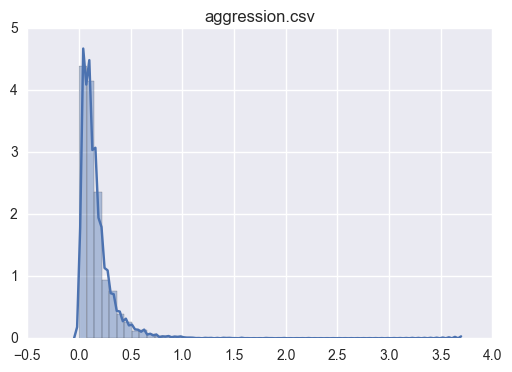

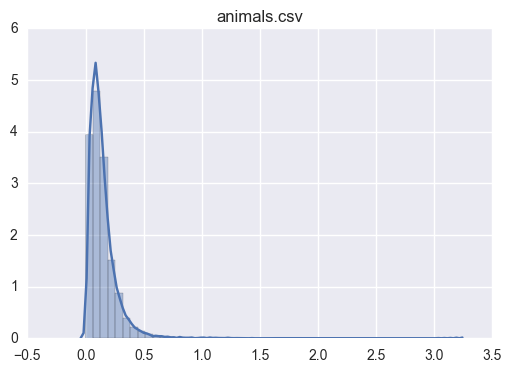

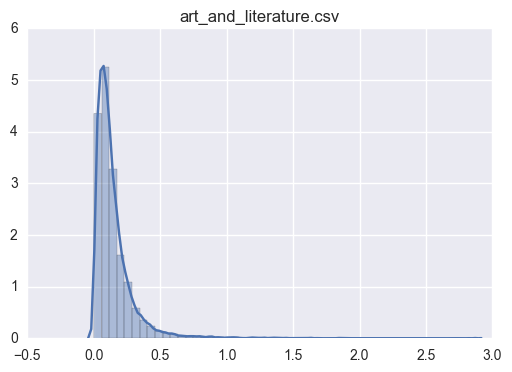

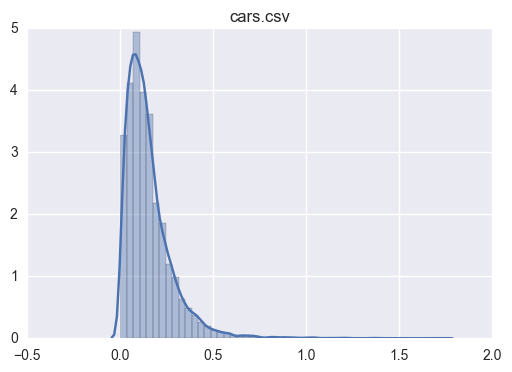

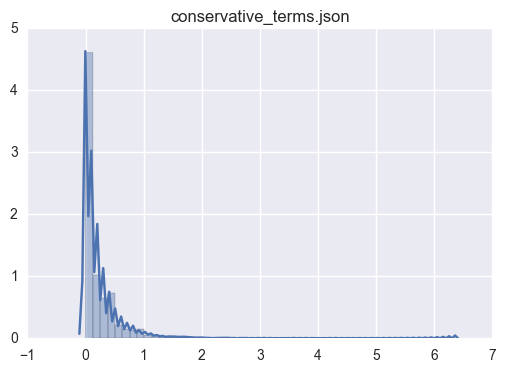

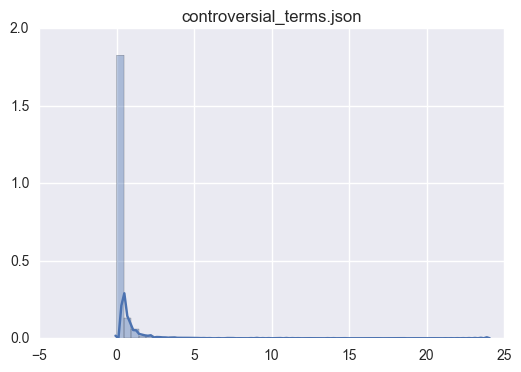

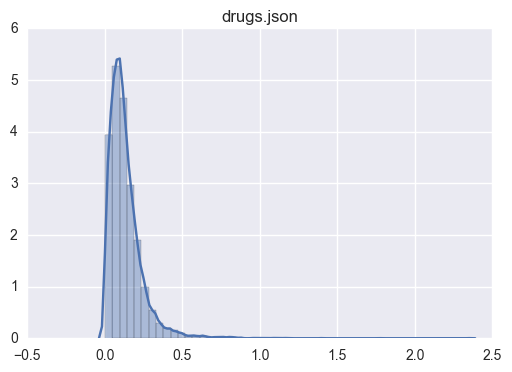

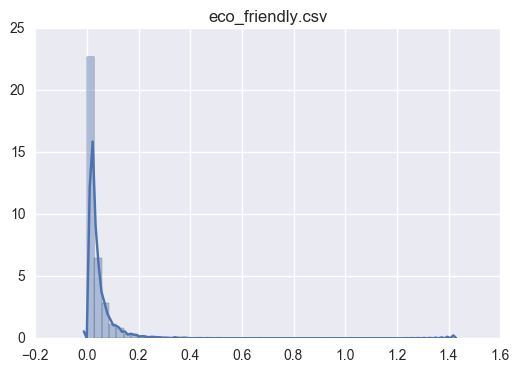

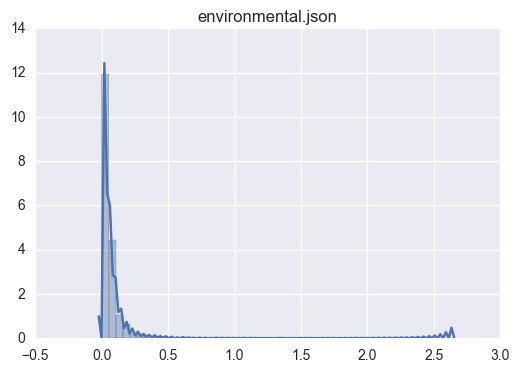

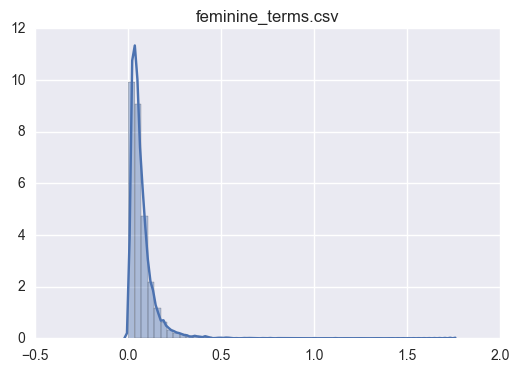

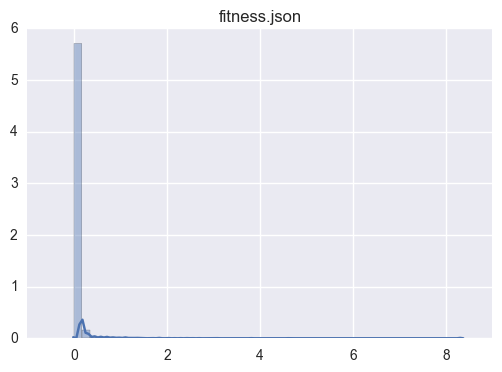

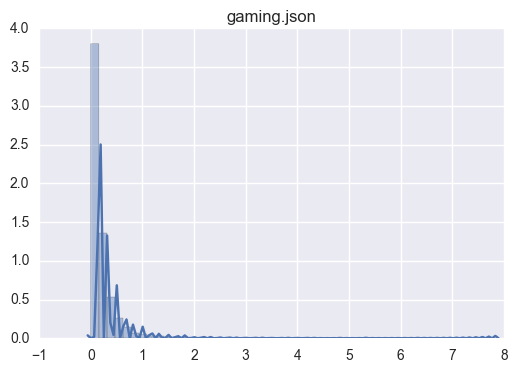

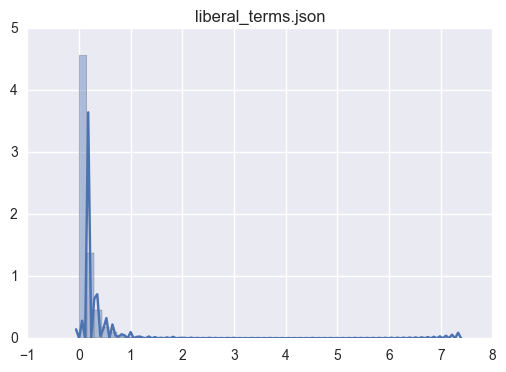

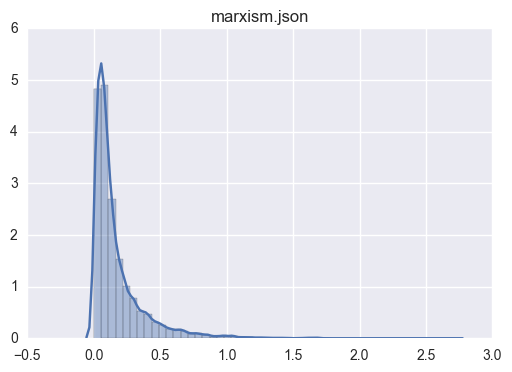

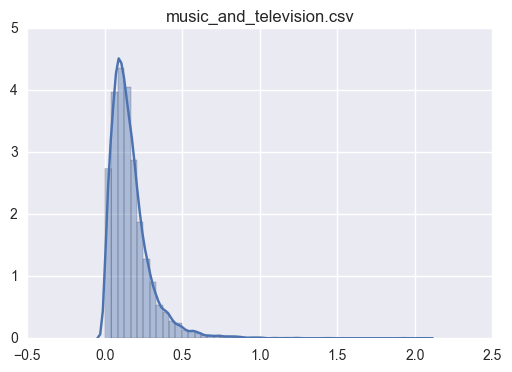

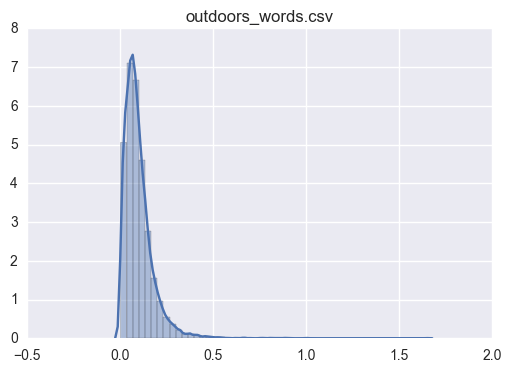

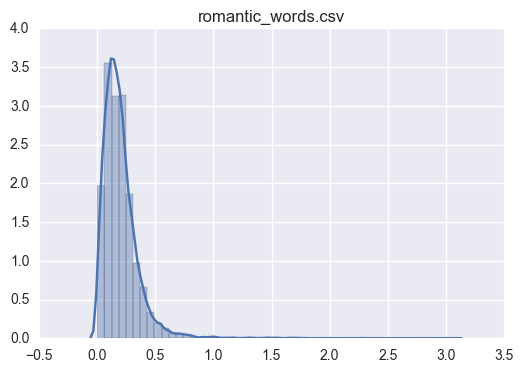

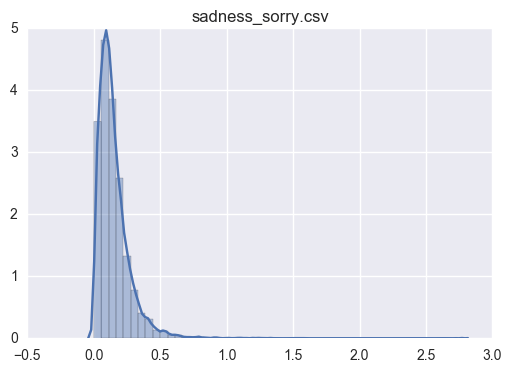

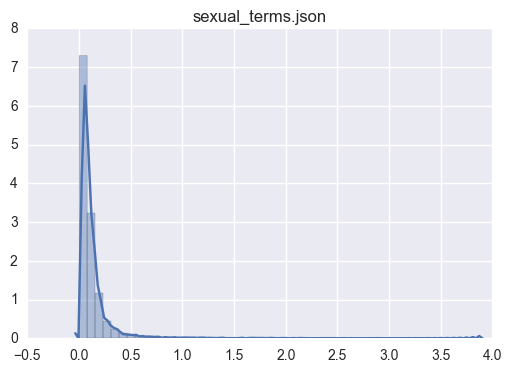

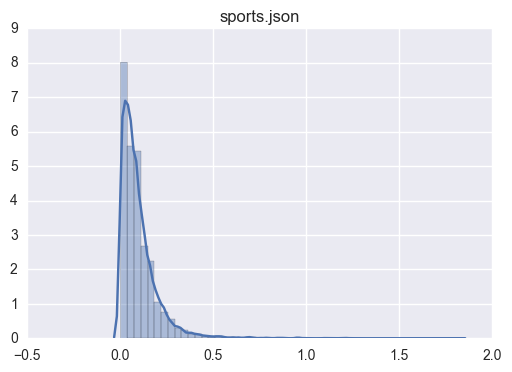

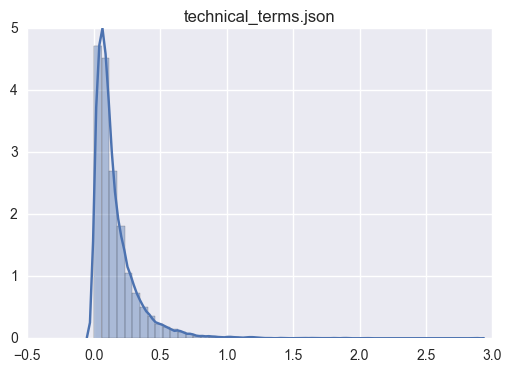

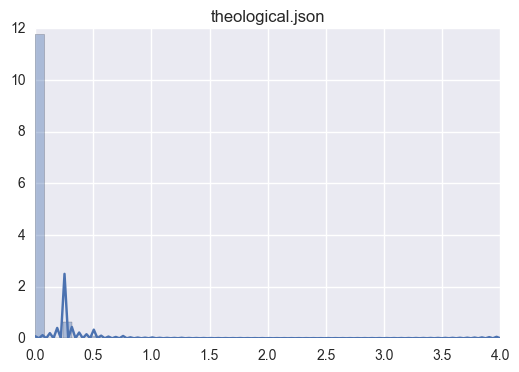

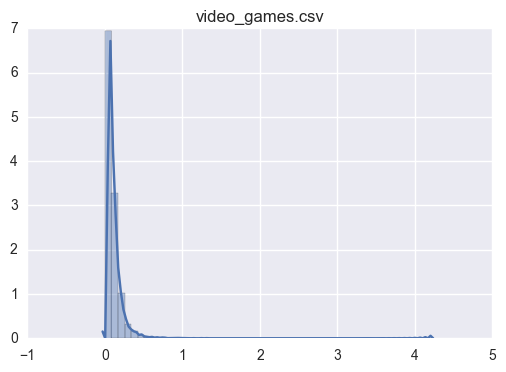

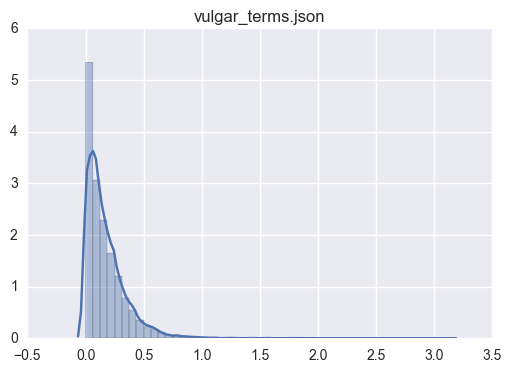

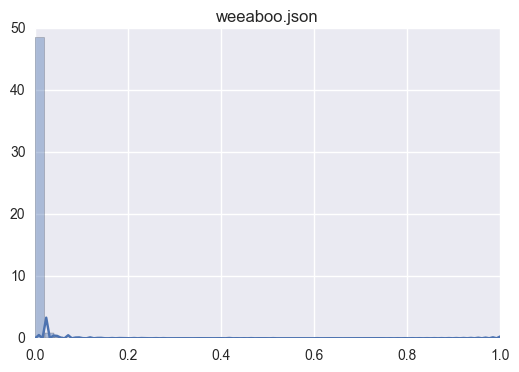

In [1206]:
for category_points ,category in zip(points,scaled_dfs[0].columns):
    sns.distplot(category_points)
    plt.title(category)
    plt.show()

In [ ]:
# All of the plots are skewed normal distributions. Lets normalize the dfs now.

In [1207]:
for i in range(len(points)):
    scaler=preprocessing.Normalizer()
    scaler.fit(points[i])
    for j in range(len(scaled_dfs)):
        scaled_dfs[j].iloc[:,i]=scaler.transform(scaled_dfs[j].iloc[:,i])[0]

/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

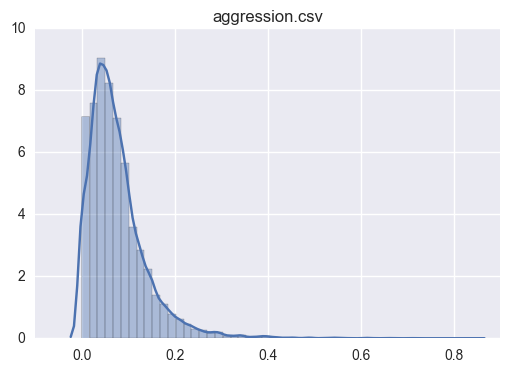

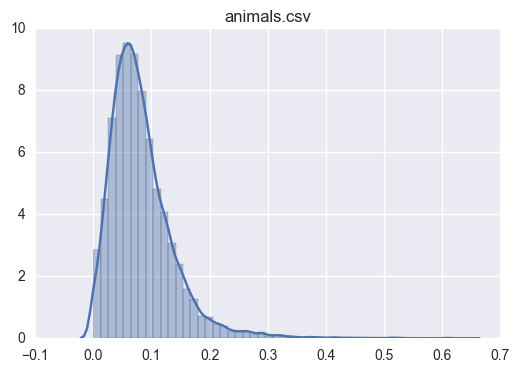

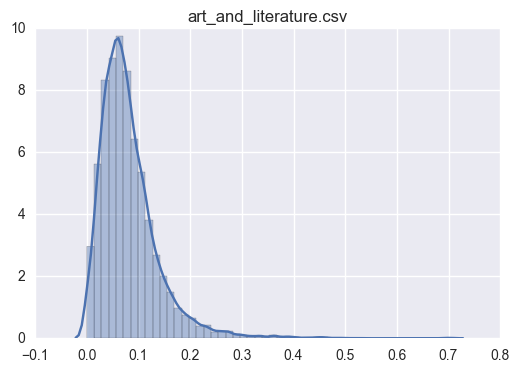

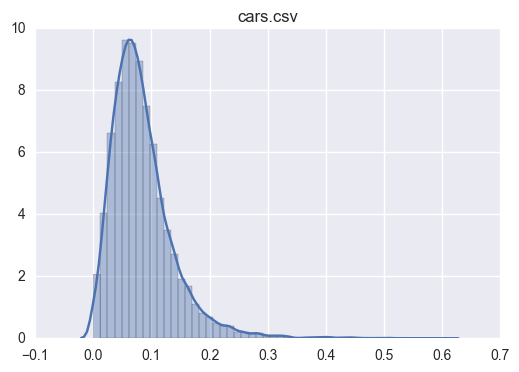

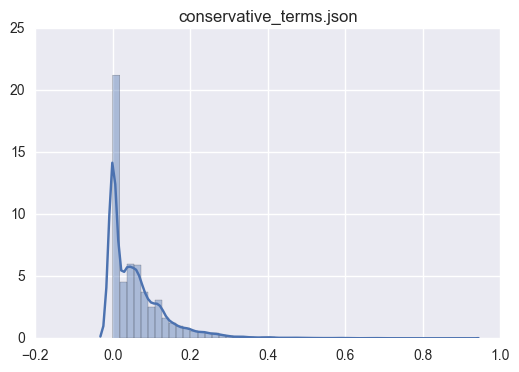

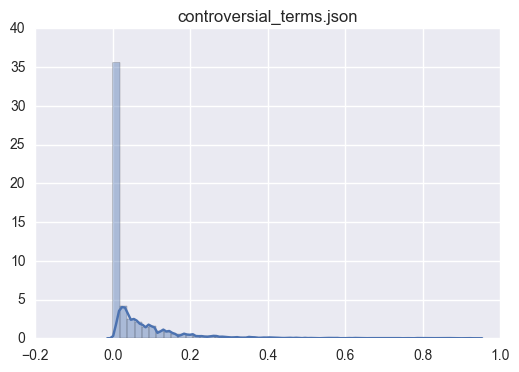

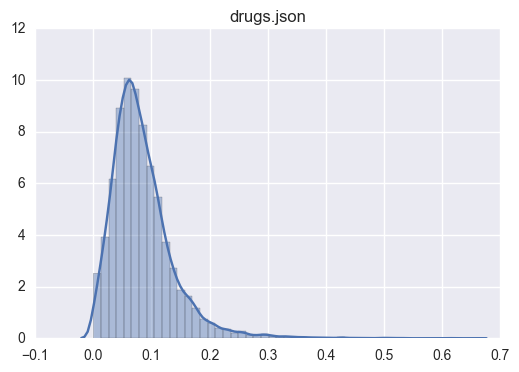

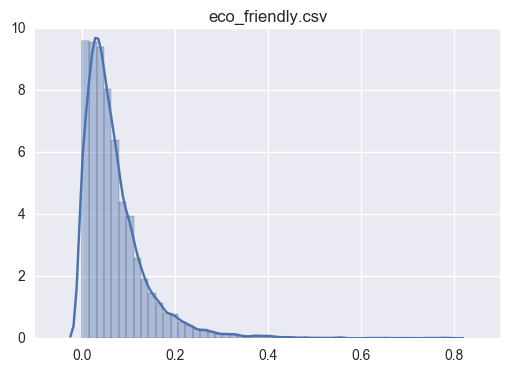

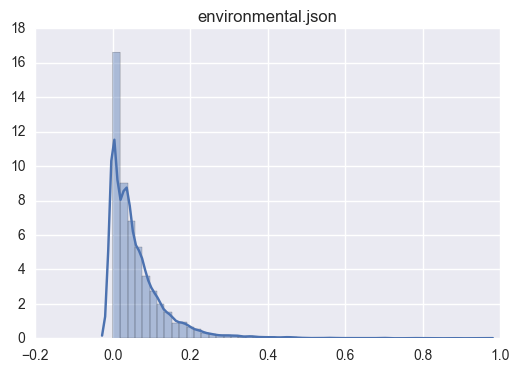

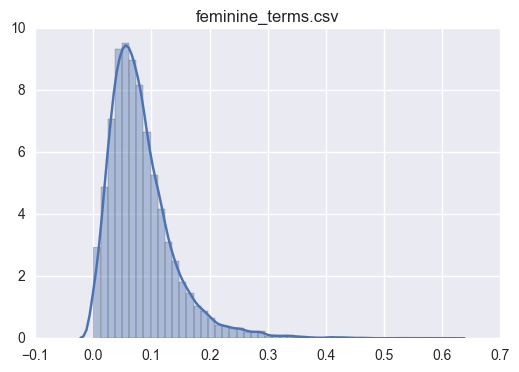

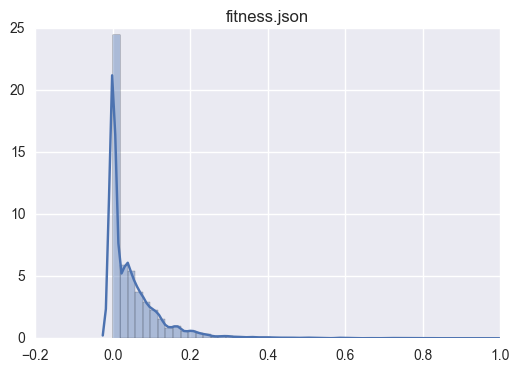

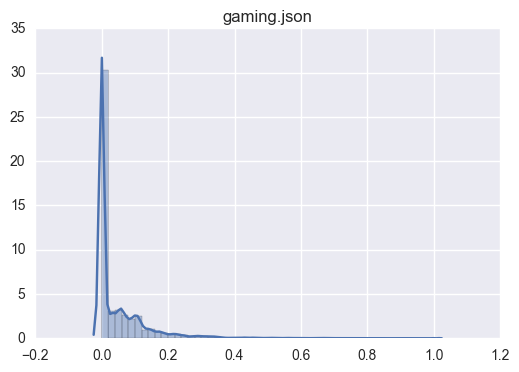

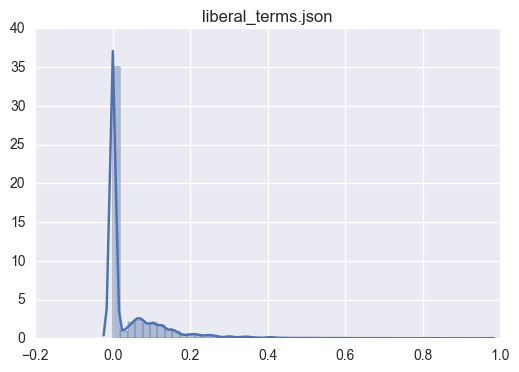

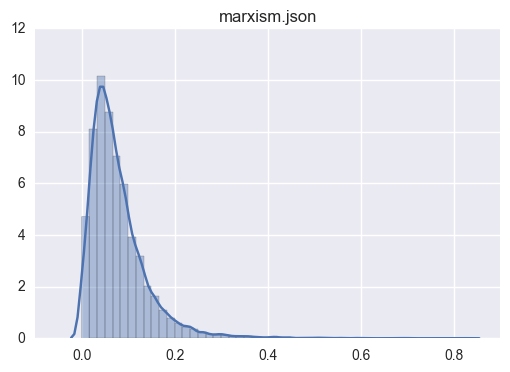

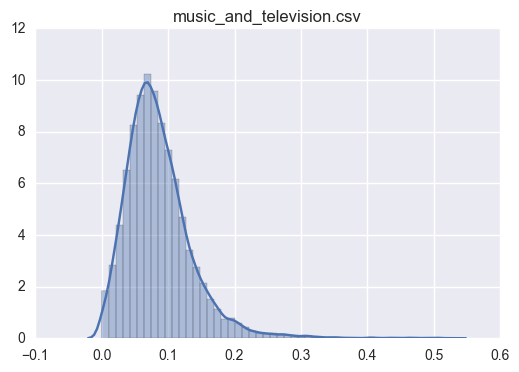

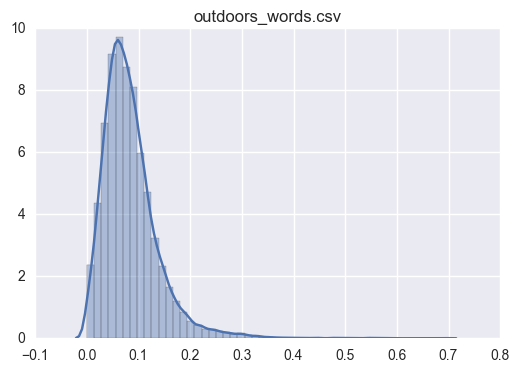

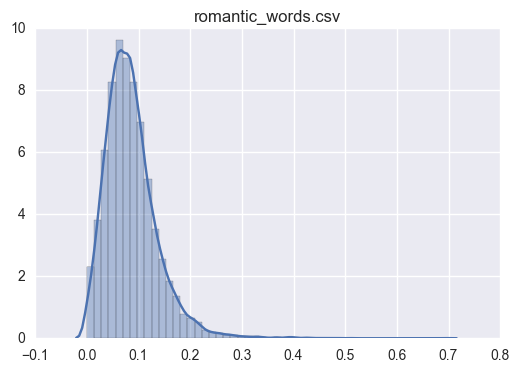

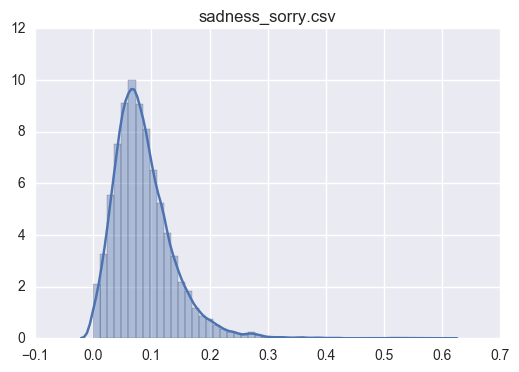

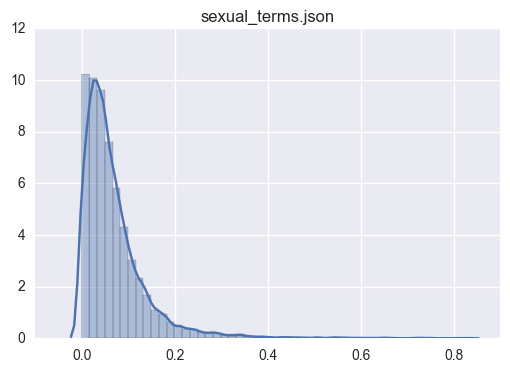

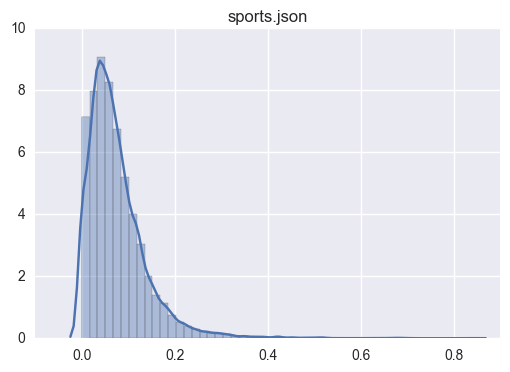

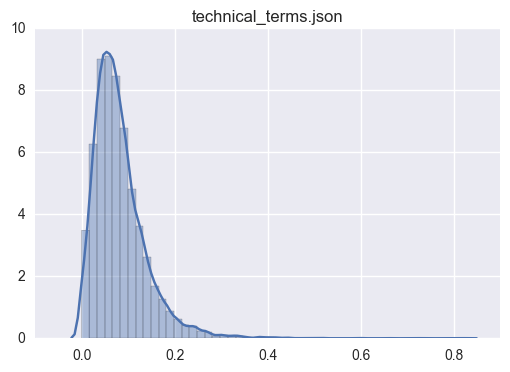

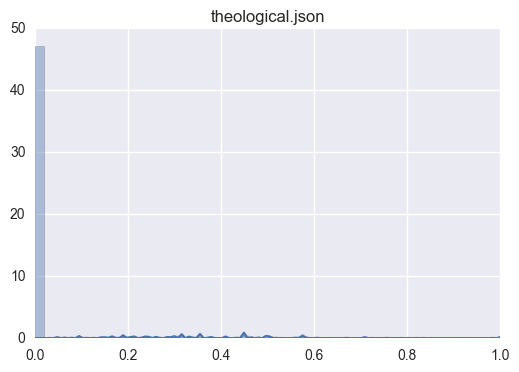

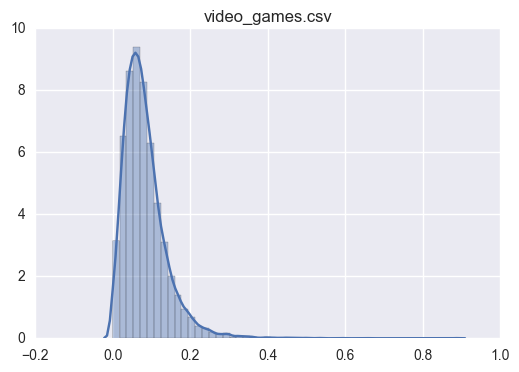

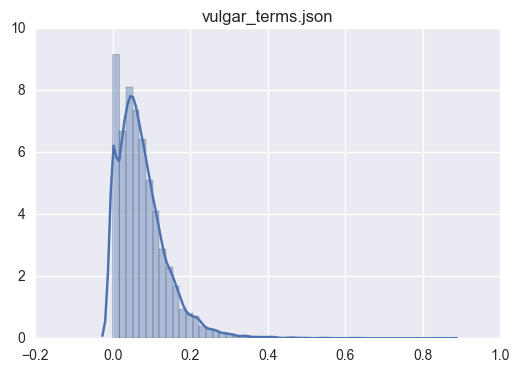

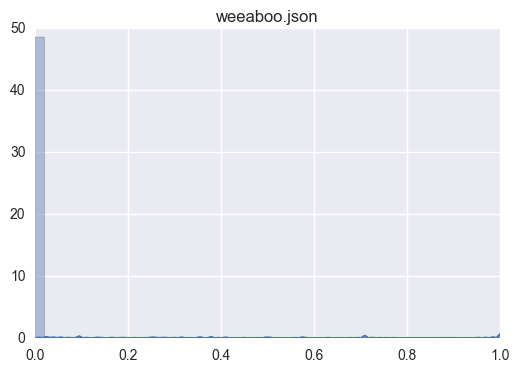

In [1208]:
# Let's replot our df's with our newly scaled data
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([x for x in df[col]])
for category_points ,category in zip(points,scaled_dfs[0].columns):
    sns.distplot(category_points)
    plt.title(category)
    plt.show()

# Functions for Clustering

### Function for Showing Most Similar Subreddits

In [2709]:
def distance_calculator(subreddit,frame):
    base_dist=frame.loc[subreddit,:]
    base_dist=base_dist[:-1]
    names=frame.index
    distances=[]
    for row in range(len(frame)):
        loc=frame.iloc[row,:-1]
        distances.append(np.sum((base_dist-loc)**2))
    points=zip(names,distances)
    points.sort(key=(lambda x:x[1]))
    return points[1:11]

### Function for coloring correlation dataframes

In [1920]:
def color(x):
    color="grey"
    x=np.abs(x)
#     if x>0.4:
#         color="Green"
    if x>0.65:
        color="white"
    if x>0.80:
        color='yellow'
    if x==1.0:
        color='black'
    if x<0.:
        color='black'
    return 'background-color: %s' %color

### Assigning Importance Weighting to each list of words

In [3706]:
def scaled(df_list):
    #List of Importance Levels
    ilev_1=1
    ilev_2=2
    ilev_3=3
    ilev_4=4
    ilev_5=10
    ilev_6=25

    # The ilev assignments aren't abitrarily chosen. The theory is that for extremely opposite traits, the level should
    # be increased to ensure that subreddits with opposite radical traits don't get grouped together.
    # Basically assigning higher ilev to things that aren't related at all 
    list_dict={u'aggression.csv':ilev_1, 
               u'animals.csv':ilev_1,
               u'art_and_literature.csv':ilev_1,
               u'cars.csv':ilev_1,
               u'companies.csv':ilev_1,
               u'conservative_terms.json':ilev_1,
               u'controversial_terms.json':ilev_1,
               u'drugs.json':ilev_1,
               u'eco_friendly.csv':ilev_1,
               u'environmental.json':ilev_1,
               u'feminine_terms.csv':ilev_1,
               u'fitness.json':ilev_1,
               u'gaming.json':ilev_1,
               u'liberal_terms.json':ilev_1,
               u'marxism.json':ilev_1,
               u'music_and_television.csv':ilev_1,
               u'outdoors_words.csv':ilev_1,
               u'romantic_words.csv':ilev_1,
               u'sadness_sorry.csv':ilev_1,
               u'sentiment_pos.csv':ilev_1,
               u'sentiment_neg.csv':ilev_1,
               u'sentiment_neutral.csv':ilev_1,
               u'sexual_terms.json':ilev_1,
               u'sports.json':ilev_1,
               u'technical_terms.json':ilev_1,
               u'theological.json':ilev_1,
               u'video_games.csv':ilev_1,
               u'vulgar_terms.json':ilev_1,
               u'weirdo.json':ilev_1}
    new_dfs=[]
    for i in range(len(scaled_dfs)):
        new_dfs.append(scaled_dfs[i].copy())
        for value in list_dict.keys():
            new_dfs[i][value]=scaled_dfs[i][value] * list_dict[value]
    return new_dfs

### Personality Maker

In [3762]:
def personalities(df_list):
    personality_dfs=[]
    plev_1=.333
    plev_2=.5
    plev_3=1
    plev_4=2
    plev_5=3
    
    for df in df_list:
        df_p=pd.DataFrame()
#         df_p['Cars']=      plev_3*(df['cars.csv'])
        df_p['Technical']= plev_3* ((df['technical_terms.json']-df['music_and_television.csv']))
        df_p['Drugs'] =    plev_3*(df['drugs.json'])
        df_p['Sporty'] =   plev_3*(((df['fitness.json'])+df['sports.json'])/2.)
        df_p['Gender'] =   plev_3*((df['animals.csv']+df['feminine_terms.csv'])/2.)#-\
#                                 (df['aggression.csv']+df['vulgar_terms.json'])/2.)
        df_p['Relaxation']=plev_3*(df['art_and_literature.csv']-((df['gaming.json']+df['video_games.csv'])/2.))
        df_p['Spare Time']=plev_3*(df['art_and_literature.csv']-df['weirdo.json'])
        df_p['Outdoors']=  plev_3*((df['outdoors_words.csv']+df['environmental.json'])/2.-\
                                  (df['cars.csv']+df['aggression.csv'])/2.)
        df_p['Inferiority']=plev_3*(df['aggression.csv']+df['vulgar_terms.json'])/2.
        df_p['Political']= plev_3*((df['liberal_terms.json']-df['conservative_terms.json']))
#         df_p['Extremes']=  plev_3*((df['marxism.json']-df['feminine_terms.csv']))
#         df_p['Weird']=     plev_3*(df['weirdo.json'])#-df['drugs.json'])
        df_p['Emotions']=  plev_3*(df['sexual_terms.json']+df['romantic_words.csv'])/2.
#         df_p["Sadness"] =  plev_3*(df['sadness_sorry.csv'])
        df_p['Troll']=     plev_3*((df['controversial_terms.json']+df['vulgar_terms.json'])/2.)
#         df_p['Total_Sentiment']= plev_3*(df['sentiment_pos.csv']+df['sentiment_neg.csv'])/2.
        df_p['Laziness'] = plev_5*((df['drugs.json']+(df['gaming.json']+df['video_games.csv'])/2.)/2.)
        df_p['Sentiment']=  plev_3*(df['sentiment_pos.csv']-df['sentiment_neg.csv'])
#         df_p["Positive"] = plev_3*(df['sentiment_pos.csv']+df['sadness_sorry.csv'])
#         df_p["Negative"] = plev_3*(df['sentiment_neg.csv']+df['sadness_sorry.csv'])
        df_p['Neutrality']=plev_3*(df['sentiment_neutral.csv']-\
                                     (df['sentiment_pos.csv']+df['sentiment_neg.csv'])/2.)
        df_p['Religious'] = plev_3*(df['companies.csv'])-(df['theological.json'])
        personality_dfs.append(df_p)
    return personality_dfs

# Scaling and Normalization for Clustering

### Scaling

In [3746]:
# We want to scale our dataframes; so lets Min_max scale each df according to its largest word, and then further scale
# each column category according to the largest count across all dfs (this will also be scaled according to the \
# largest number of words in a df)

### Mathematically, the scaling operation above equates to the columns being divided by the max count of each category
max_words_in_df=[]
max_words_in_cat={}
for col in category_dfs[0].columns:
    max_words_in_cat[col]=0
for df in category_dfs:
    curr_max_words=0
    max_col=max(df[col])
    for col in df:
# First, find maximum word count for each category across all dfs
        if max_col>max_words_in_cat[col]:
            max_words_in_cat[col]=np.mean(df[col])
# Then, find maximum number of words in each df
        if max_col>curr_max_words:
            curr_max_words=max_col
    max_words_in_df.append(curr_max_words)


# Then, scale the dfs in a fresh dataframe object.
scaled_dfs=[]
for i in range(len(category_dfs)):
    temp_df=category_dfs[i].copy()
    for col in temp_df:
        temp_df[col]=temp_df[col]/float(max_words_in_cat[col])
    scaled_dfs.append(temp_df)
# As it turns out, there are no anarchy words across any data_frame. We can remove this column
# If we wanted to keey this columns, we would just change the default dictionary starting value to '1'
for i in range(len(scaled_dfs)):
    del scaled_dfs[i]['anarchy.json']

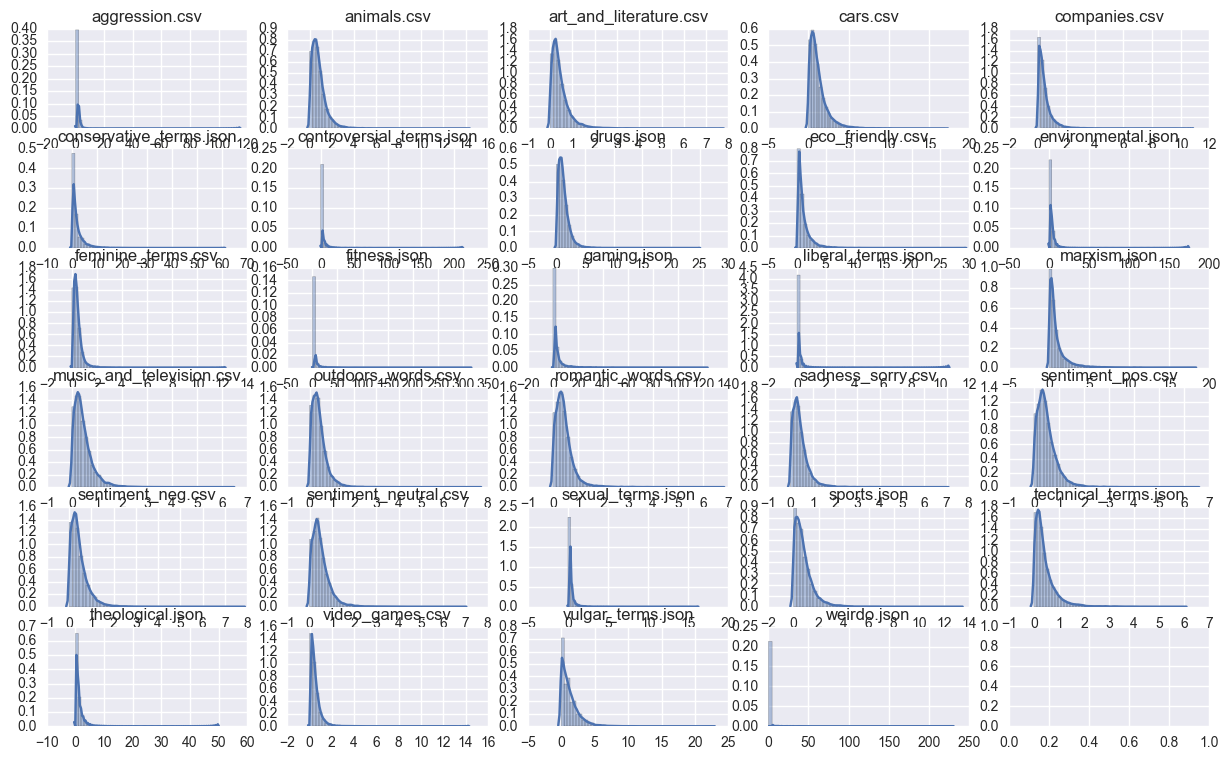

In [3681]:
plt.subplots(6,5,figsize=(15,9))
i=1
for category_points ,category in zip(points,scaled_dfs[0].columns):
    plt.subplot(6,5,i)
    sns.distplot(category_points)
    plt.title(category)
    i+=1
plt.show()

In [3682]:
subreddit_means=[]
for df in scaled_dfs:
    subreddit_means.append([])
    for col in df.columns:
        subreddit_means[-1].append(np.mean(df[col]))
temp_df=pd.DataFrame(subreddit_means,columns=category_lists2,index=subreddit_list)
temp1=temp_df.corr()#.style.applymap(color)
# temp1=temp1-.5
temp1.style.applymap(color)

### Normalization

In [3747]:
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([float(x) for x in df[col]])
for i in range(len(points)):
    scaler=preprocessing.Normalizer()
    scaler.fit(np.array(points[i]).reshape(1,-1))
    for j in range(len(scaled_dfs)):
#         scaled_dfs[j].iloc[:,i]=preprocessing.minmax_scale(scaler.transform(scaled_dfs[j].iloc[:,i].reshape(1,-1))[0])
        scaled_dfs[j].iloc[:,i]=preprocessing.minmax_scale(np.log(.5+preprocessing.minmax_scale(\
                                        scaler.transform(scaled_dfs[j].iloc[:,i].values.reshape(1, -1))[0])))

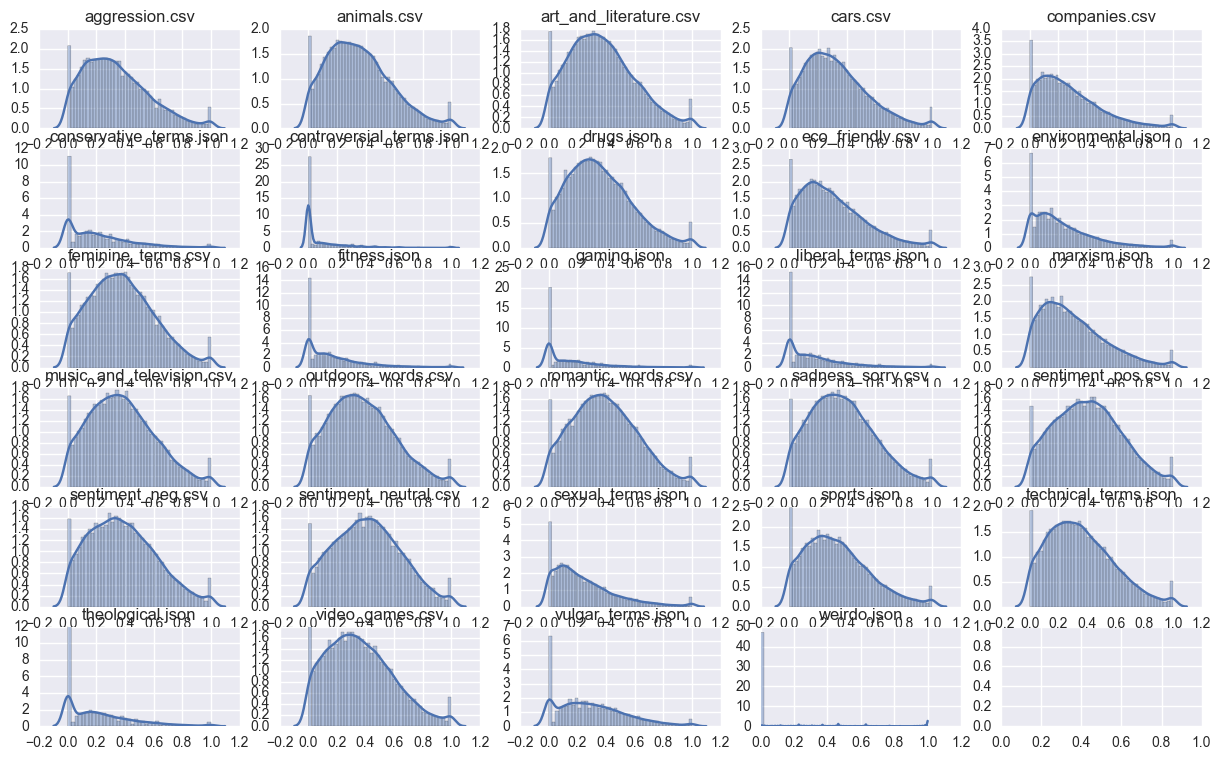

In [3754]:
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([x for x in df[col]])
plt.subplots(6,5,figsize=(15,9))
i=1
for category_points ,category in zip(points,scaled_dfs[0].columns):
    plt.subplot(6,5,i)
    sns.distplot(category_points)
    plt.title(category)
    i+=1
plt.show()

In [3685]:
subreddit_means=[]
for df in scaled_dfs:
    subreddit_means.append([])
    for col in df.columns:
        subreddit_means[-1].append(np.mean(df[col]))
temp_df=pd.DataFrame(subreddit_means,columns=category_lists2,index=subreddit_list)
temp1=temp_df.corr()#.style.applymap(color)
# temp1=temp1-.5
temp1.style.applymap(color)

# Clustering

In [3775]:
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit']]
exclude_names=pd.read_csv('ignore_subreddits.csv')
exclude_list=['Subreddit Data/'+x[3:]+'.json' for x in exclude_names['Reddit']]
subreddit_list=[x for x in subreddit_list if x not in exclude_list]

# 'personalities' or 'scaled'
df_list_to_use=scaled(scaled_dfs)

clus=25 # NUMBER OF CLUSTERS
comp=len(df_list_to_use[0].columns) # NUMBER OF PRINCIPAL COMPONENTS
link_mod=0.25

for i in range(len(df_list_to_use)):
    for col in df_list_to_use[i].columns:
        df_list_to_use[i].loc[:,col]=preprocessing.minmax_scale([float(x) for x in \
                                                    df_list_to_use[i].loc[:,col]])[0]
    link_type=all_post_types[i]
    df_list_to_use[i]["jpg"]=[link_mod if x=='jpg' else 0 for x in link_type]
    df_list_to_use[i]["gif"]=[link_mod if x=='gif' else 0 for x in link_type]
    df_list_to_use[i]["com"]=[link_mod if x=='com' else 0 for x in link_type]
    df_list_to_use[i]["png"]=[link_mod if x=='png' else 0 for x in link_type]
    df_list_to_use[i]["htm"]=[link_mod if x=='htm' else 0 for x in link_type]

# Find mean of each column for each df. Put it into new df. Purpose is to start clustering.
subreddit_means=[]
for df in df_list_to_use:
    subreddit_means.append([])
    for col in df.columns:
        subreddit_means[-1].append(np.mean(df[col]))
subreddits_transformed_model=PCA(n_components=comp).fit(subreddit_means)
subreddits_transformed=subreddits_transformed_model.transform(subreddit_means).reshape(comp,-1)
model=cluster.KMeans(n_clusters=clus,)
model.fit(subreddits_transformed.reshape(-1,comp))
pred=model.predict(subreddits_transformed.reshape(-1,comp))
grouped_pred=pd.DataFrame(subreddits_transformed,columns=[x[15:-5] for x in subreddit_list]).T
grouped_pred["Group"]=pred
grouped_pred=grouped_pred

In [3776]:
distance_calculator('The_Donald',grouped_pred)

[('polandball', 0.8133762347942929),
 ('SandersForPresident', 0.813612472176225),
 ('gameofthrones', 0.9345538684725515),
 ('whatisthisthing', 0.9456684289762849),
 ('apple', 0.9493358667645789),
 ('FanTheories', 0.9559298471209524),
 ('Unexpected', 0.9619753882343353),
 ('instant_regret', 1.0047255975380713),
 ('food', 1.007791493266518),
 ('EarthPorn', 1.0343374791876465)]

In [3777]:
distance_calculator('technology',grouped_pred)

[('circlejerk', 1.5312208028791303),
 ('bestof', 2.172890225615905),
 ('trashy', 2.228063746504679),
 ('whatisthisthing', 2.3905358021913274),
 ('Eyebleach', 2.4313305731278647),
 ('iamverysmart', 2.4502431825617905),
 ('FanTheories', 2.4598139425587022),
 ('JusticePorn', 2.498437158230944),
 ('business', 2.504730414621118),
 ('space', 2.5485570727132494)]

In [3778]:
distance_calculator('EarthPorn',grouped_pred)


[('Fitness', 0.6575100192689123),
 ('breakingbad', 0.8183314345630988),
 ('DepthHub', 0.8389776558025778),
 ('cringepics', 0.8569773107067414),
 ('FanTheories', 0.8916739734996572),
 ('gameofthrones', 0.9118058039559239),
 ('whatisthisthing', 0.9150832370478021),
 ('relationships', 0.9459045169832474),
 ('SkincareAddiction', 0.9468609532086011),
 ('polandball', 0.9768059203683351)]

In [3779]:
distance_calculator('gaming',grouped_pred)


[('doctorwho', 0.7698937364217067),
 ('fantasyfootball', 0.8475749198227837),
 ('photoshopbattles', 0.8855366742378102),
 ('soccer', 0.9047699198889826),
 ('Eyebleach', 0.9108339903182816),
 ('videos', 0.9267069415968248),
 ('gameofthrones', 0.9285120146756872),
 ('Fitness', 1.0247224320215254),
 ('de_IAmA', 1.034752941353138),
 ('Entrepreneur', 1.0541428451279078)]

In [3780]:
distance_calculator('nonononoyes',grouped_pred)


[('youdontsurf', 1.4532103947948327),
 ('videos', 2.6636493244341346),
 ('travel', 3.134010689063369),
 ('offmychest', 3.2637220721099527),
 ('SkincareAddiction', 3.3155020979469647),
 ('Fallout', 3.3179713228843),
 ('listentothis', 3.371747455625956),
 ('geek', 3.3981423213740487),
 ('gaming', 3.4470266470480904),
 ('mildlyinfuriating', 3.4602945707984807)]

In [3601]:
for i in range(len(grouped_pred['Group'].unique())):
    print "GROUP %i" %(i+1)
    for x in grouped_pred[grouped_pred['Group']==i].index:
        print x
    print

GROUP 1
history
WTF
Frugal
oddlysatisfying
HistoryPorn
wheredidthesodago
AbandonedPorn
TumblrInAction
thatHappened
Whatcouldgowrong
holdmybeer
QuotesPorn
Eyebleach
trashy
doctorwho
MMA

GROUP 2
news
sports
InternetIsBeautiful
Art
europe
pokemon
soccer
comics
talesfromtechsupport
loseit
EatCheapAndHealthy
mildlyinfuriating
whatisthisthing
linux
FanTheories
HighQualityGifs

GROUP 3
IAmA
DIY
tifu
Documentaries
sex
GlobalOffensive
buildapc
apple
firstworldanarchists
dadjokes
seduction

GROUP 4
interestingasfuck
PerfectTiming

GROUP 5
movies
blog
woahdude
reddit.com
StarWars
hiphopheads
shittyaskscience
spaceporn
asoiaf
geek
LearnUselessTalents
harrypotter
youdontsurf
AnimalsBeingBros

GROUP 6
gadgets
pcmasterrace
me_irl
hearthstone
KenM

GROUP 7
askscience
philosophy
JusticePorn
TrueReddit
AnimalsBeingJerks
MakeupAddiction
hockey
TalesFromRetail
UnexpectedThugLife

GROUP 8
funny
food
TwoXChromosomes

GROUP 9
mildlyinteresting
nottheonion
WritingPrompts
atheism
4chan
nba
wow
FiftyFifty
phot

Our explained variance ratio explains just how finicky the model is. One small change in an axis can lose a lot of inforamtion!

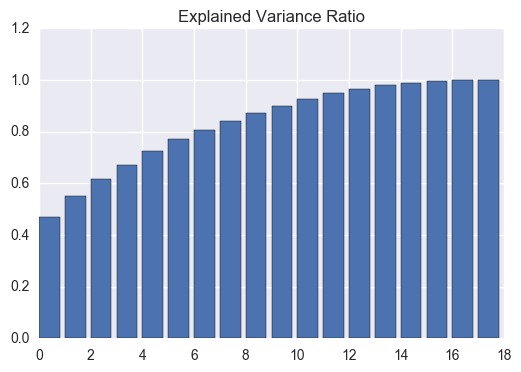

In [3502]:
digits=np.cumsum(subreddits_transformed_model.explained_variance_ratio_)
plt.bar(range(len(digits)),digits)
plt.title('Explained Variance Ratio')
plt.show()

With the explained variance ratio being so difficult above, it would make sense that our cluster data can not be explained in 2 dimensions.

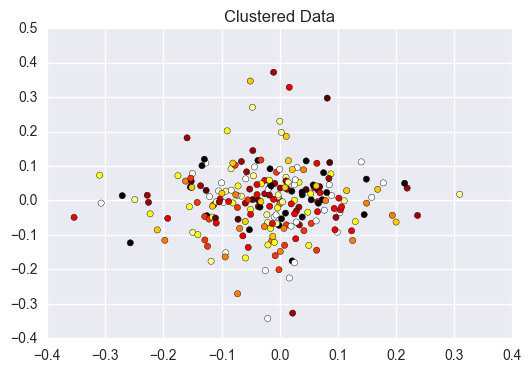

In [3278]:
plt.scatter(grouped_pred[0],grouped_pred[1],c=pred,cmap='hot')
plt.title('Clustered Data')
plt.show()